# Train Your Very First Pytorch Model!


Let's learn through doing.

In this notebook we will create an image classifier to detect garbage classification.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 1.26.4
Pandas version 2.2.3


# Step 1. Pytorch Dataset (and Dataloader)

Would you learn how to bake a cake without first having the ingredients? No.

The same thing can be said for training a pytorch model without first having the dataset setup correctly.

This is why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [91]:
class GarbageDataset(Dataset):
    def __init__(self,data_dir,transform=None):
        self.data=ImageFolder(data_dir,transform=transform)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
        
    
    

## Create Test Dataset

In [92]:
dataset=GarbageDataset(
   data_dir='/kaggle/input/garbage-classification/Garbage classification/Garbage classification'
)

In [93]:
len(dataset)

2527

2


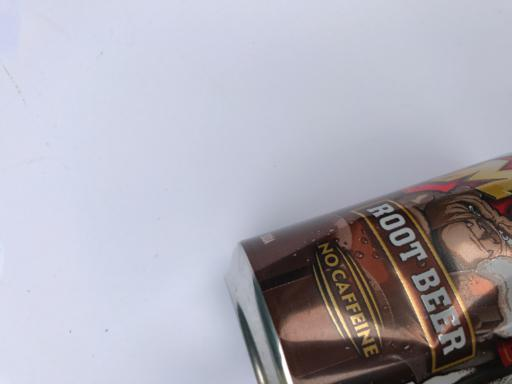

In [94]:
idx=np.random.choice(len(dataset))
image,label=dataset[idx]
print(label)
image

In [95]:
data_dir='/kaggle/input/garbage-classification/Garbage classification/Garbage classification'
target_to_class={v:k for k,v in ImageFolder(data_dir).class_to_idx.items()}
target_to_class

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [96]:
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
data_dir='/kaggle/input/garbage-classification/Garbage classification/Garbage classification'
dataset=GarbageDataset(data_dir,transform)

In [97]:
image,label=dataset[100]
image.shape

torch.Size([3, 128, 128])

## Splitting Data:

In [98]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

## Dataloaders

- Batching our dataset
- It's faster to train the model in batches instead of one at a time.

In [99]:
batch_size=32
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [100]:
for images,labels in train_dl:
    break
images.shape,labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

## First batch labels

In [101]:
labels

tensor([1, 3, 2, 0, 4, 0, 2, 3, 3, 1, 2, 0, 4, 3, 1, 1, 0, 4, 2, 2, 1, 3, 4, 1,
        3, 2, 4, 3, 2, 4, 3, 4])

## This is a helper function to visualize batches:

In [102]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images,label in dl:
        fig,ax=plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break
        
        

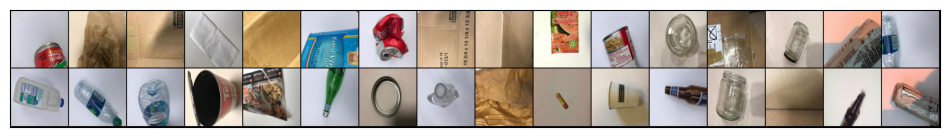

In [103]:
show_batch(train_dl)

## Create Model

In [104]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        return loss
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))     

## We'll be using ResNet50 for classifying images:

In [105]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network=models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
model = ResNet()        

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [106]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [107]:
device = get_default_device()
device

device(type='cpu')

In [108]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

This is the function for fitting the model.

In [109]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [110]:
model = to_device(ResNet(), device)

In [111]:
evaluate(model, val_dl)

{'val_loss': 1.816113829612732, 'val_acc': 0.1163194477558136}

Let's start training the model:

In [112]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.5076, val_loss: 1.2736, val_acc: 0.8542
Epoch 2: train_loss: 1.2053, val_loss: 1.1770, val_acc: 0.9184
Epoch 3: train_loss: 1.1010, val_loss: 1.1626, val_acc: 0.8993
Epoch 4: train_loss: 1.0764, val_loss: 1.1442, val_acc: 0.8924
Epoch 5: train_loss: 1.0611, val_loss: 1.1313, val_acc: 0.9271
Epoch 6: train_loss: 1.0563, val_loss: 1.1401, val_acc: 0.9010
Epoch 7: train_loss: 1.0553, val_loss: 1.1369, val_acc: 0.9115
Epoch 8: train_loss: 1.0549, val_loss: 1.1289, val_acc: 0.8993


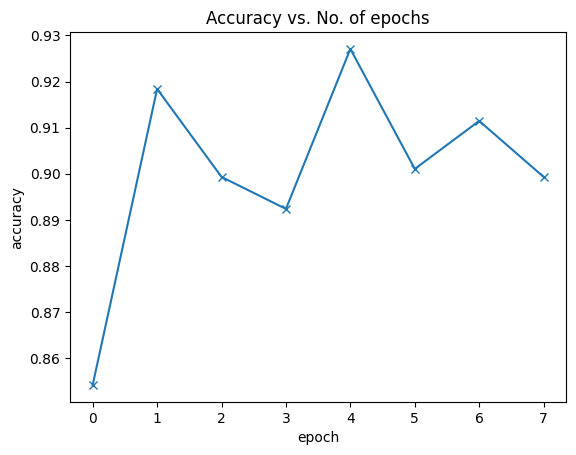

In [113]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

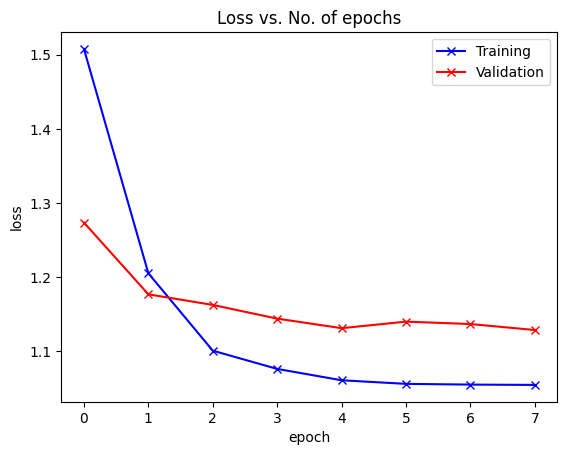

In [114]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualizing Predictions:

In [115]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

Label: paper , Predicted: paper


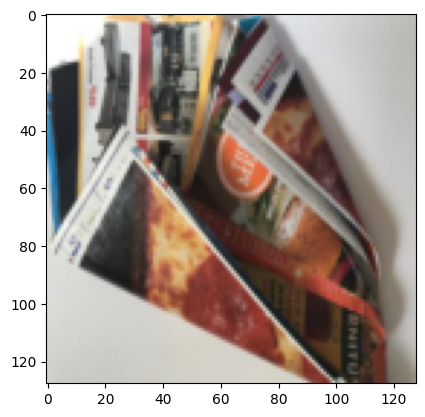

In [116]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: cardboard , Predicted: cardboard


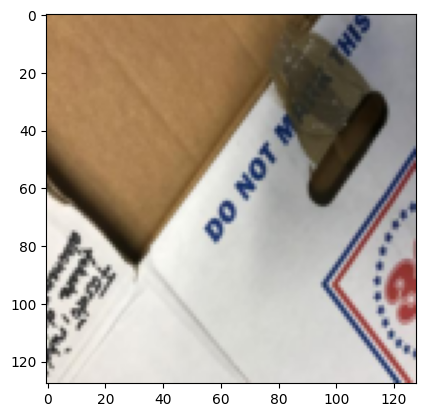

In [117]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: cardboard , Predicted: cardboard


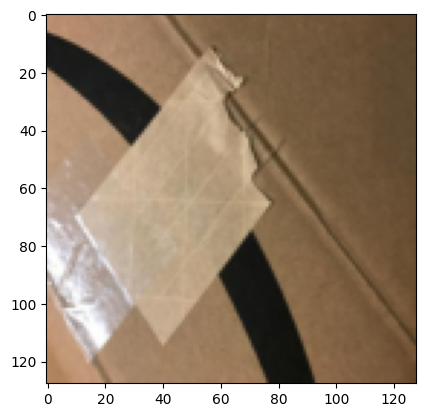

In [118]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [119]:
import urllib.request
urllib.request.urlretrieve("https://images.unsplash.com/photo-1616118132534-381148898bb4?auto=format&fit=crop&q=80&w=1000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8cGxhc3RpYyUyMGJvdHRsZXxlbnwwfHwwfHx8MA%3D%3D", "1.jpg")
urllib.request.urlretrieve("https://www.wastemanaged.co.uk/wp-content/uploads/2023/02/Blog-Images-2023-02-09T154829.921.jpg", "2.jpg")    
urllib.request.urlretrieve("https://media.istockphoto.com/id/950590270/th/%E0%B8%A3%E0%B8%B9%E0%B8%9B%E0%B8%96%E0%B9%88%E0%B8%B2%E0%B8%A2/%E0%B9%81%E0%B8%9C%E0%B9%88%E0%B8%99%E0%B8%AD%E0%B8%B1%E0%B8%94%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B9%81%E0%B8%A2%E0%B8%81%E0%B9%84%E0%B8%94%E0%B9%89%E0%B8%9A%E0%B8%99%E0%B8%9E%E0%B8%B7%E0%B9%89%E0%B8%99%E0%B8%AB%E0%B8%A5%E0%B8%B1%E0%B8%87%E0%B8%AA%E0%B8%B5%E0%B8%82%E0%B8%B2%E0%B8%A7.jpg?s=612x612&w=0&k=20&c=_iwuIySAYeQsYD1xa_YHYVXUhDYUXCieYLd4mLfp3eE=", "3.jpg") 
urllib.request.urlretrieve("https://3.bp.blogspot.com/-u4Grbg5nz28/WYaB1YY7KII/AAAAAAAAi3I/jSEfbT76_Iogg2k45XK8eFnaHDgRSsMBgCLcBGAs/s1600/magnum_wine_bottle.jpg", "4.jpg")
urllib.request.urlretrieve("https://www.onegreenplanet.org/wp-content/uploads/2012/10/Paper-Waste-Go-Paperless.jpeg", "5.jpg")

('5.jpg', <http.client.HTTPMessage at 0x7f9ea3fdefd0>)

Let us load the model. You can load an external pre-trained model too!

In [120]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [123]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image =transform(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles plastic.


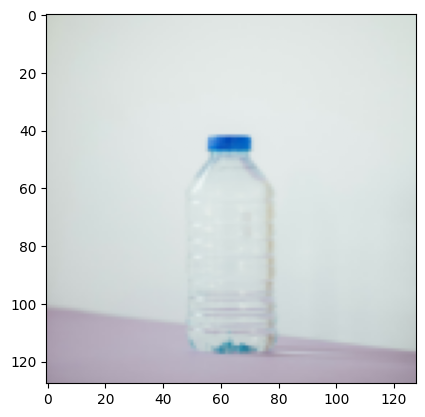

In [124]:
predict_external_image('1.jpg')

The image resembles cardboard.


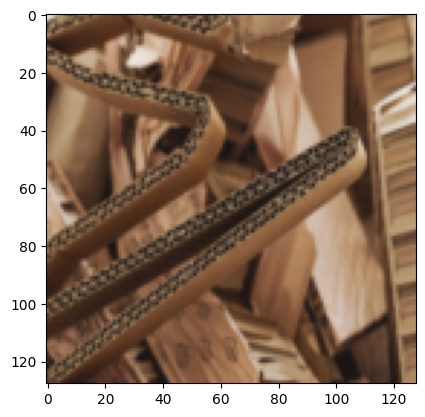

In [125]:
predict_external_image('2.jpg')

The image resembles metal.


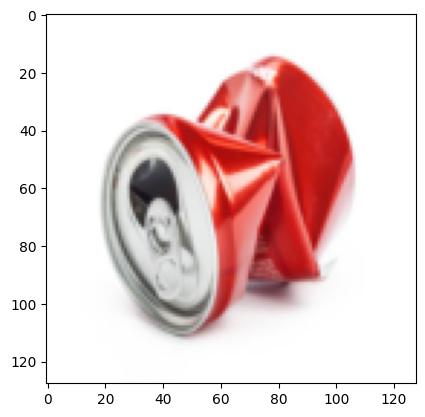

In [126]:
predict_external_image('3.jpg')

The image resembles glass.


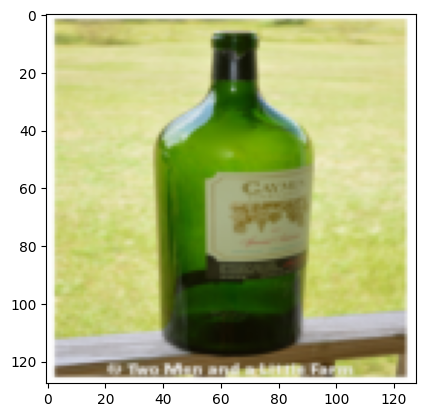

In [127]:
predict_external_image('4.jpg')

The image resembles trash.


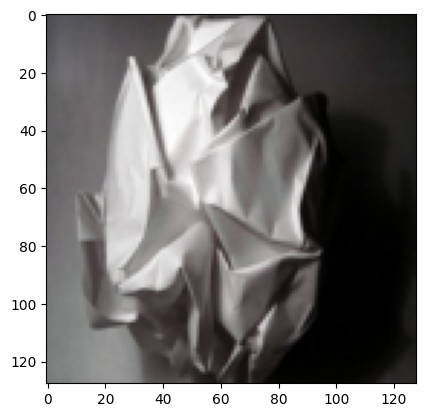

In [128]:
predict_external_image('5.jpg')